### Plotting the manually classified pixels over the images

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [3]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [4]:
!pip install scikit-image

### veg_00108  (South Facing @ ~2pm)

In [ ]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [ ]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

In [ ]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

In [ ]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

In [ ]:
rgb = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]].copy()
rgb /= rgb.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 corrected RGB Image')
ax.imshow(rgb, aspect=0.5)
plt.show()

In [10]:
print(rgb.min())

0.03820759903331387


In [27]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


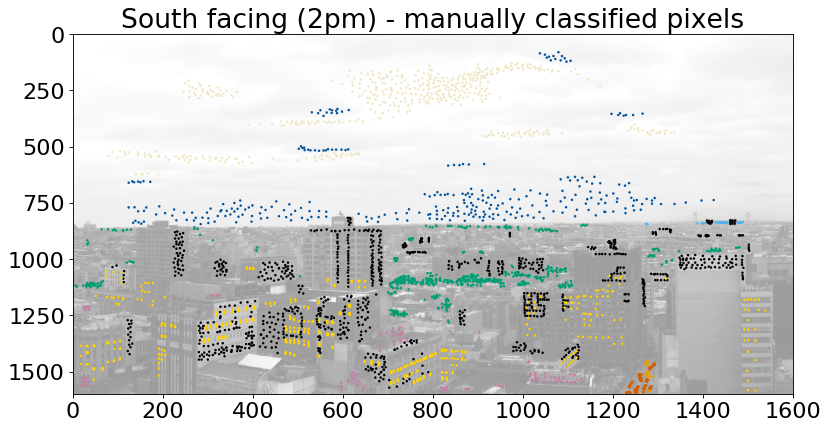

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.color import rgb2gray

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

grayscale=rgb2gray(rgb)

xpixels, ypixels = 1600, 1600
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
ax.imshow(grayscale, cmap=plt.cm.gray, interpolation='none', aspect=0.5, alpha=0.4)

g1 = ([sky_coords[:,1]], [sky_coords[:,0]])
g2 = ([clouds_coords[:,1]], [clouds_coords[:,0]])
g3 = ([veg_coords[:,1]], [veg_coords[:,0]])
g4 = ([wtr_coords[:,1]], [wtr_coords[:,0]])
g5 = ([blt_coords[:,1]], [blt_coords[:,0]])
g6 = ([windows_coords[:,1]], [windows_coords[:,0]])
g7 = ([rds_coords[:,1]], [rds_coords[:,0]])
g8 = ([cars_coords[:,1]], [cars_coords[:,0]])
g9 = ([mtl_coords[:,1]], [mtl_coords[:,0]])

data = (g1, g2, g3,  g4, g5, g6, g7, g8, g9)
colors = ([0,0.32549,0.62353,1], #sky: UD blue
          [0.93333,0.9098,0.77255,1],#clouds: UD beige
          [0,0.61961,0.45098,1],  #veg: bluish green
          [0.33725,0.70588,0.91373,1], #water: sky blue
          [0,0,0,1], #built: black
          [1,0.82353,0,1],#windows: UD Gold
          [0.90196,0.62353,0,1],  #roads: orange
          [0.83529,0.36863,0,1],   #cars: vermillion
          [0.8,0.47451,0.65490,1]       #metal: reddish purple
         )
groups = ("sky", "clouds", "vegetation", "water", "built", "windows", "roads", "cars", "metal")

for data, color, group in zip(data, colors, groups):
  x, y = data
  plt.scatter(x, y, alpha=1.0, c=color, edgecolors='none', s=5, label=group)

ax.set_ylim(1600,0)
ax.locator_params(nbins=7, axis='y')
plt.title('South facing (2pm) - manually classified pixels')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.show()
fig.savefig("./plots/Manually_classified_pixels_108.png", bbox_inches='tight')

### veg_00000  (South Facing @ ~6pm)

In [10]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [11]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [12]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


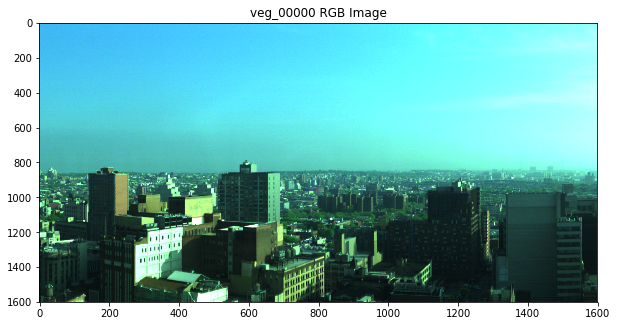

In [29]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


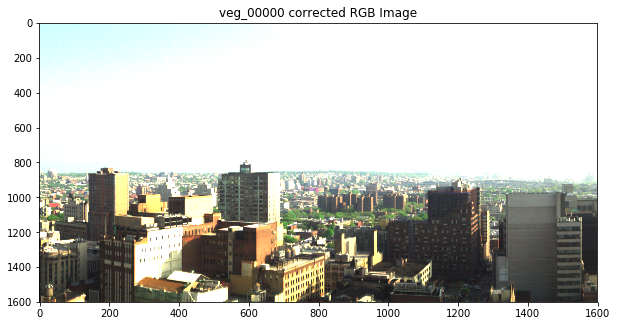

In [30]:
rgb0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]].copy()
rgb0 /= rgb0.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 corrected RGB Image')
ax.imshow(rgb0, aspect=0.5)
plt.show()

In [31]:
# read manually selected coordinates files

#sky coordinates
sky_file0 = open("../manual_classified_pixels/1_sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print("sky:        ", sky_coords0.shape)

#clouds coordinates
clouds_file0 = open("../manual_classified_pixels/2_clouds_coordinates_000.txt", "r")
clouds_coords0 = clouds_file0.readlines()
clouds_file0.close()
clouds_coords0 = np.array([point_from_string(line) for line in clouds_coords0])
print("clouds:     ", clouds_coords0.shape)

#vegetation coordinates
veg_file0 = open("../manual_classified_pixels/3_vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print("vegetation: ", veg_coords0.shape)

#water coordinates
wtr_file0 = open("../manual_classified_pixels/4_water_coordinates_000.txt", "r")
wtr_coords0 = wtr_file0.readlines()
wtr_file0.close()
wtr_coords0 = np.array([point_from_string(line) for line in wtr_coords0])
print("water:      ", wtr_coords0.shape)

#buildings coordinates
blt_file0 = open("../manual_classified_pixels/5_buildings_coordinates_000.txt", "r")
blt_coords0 = blt_file0.readlines()
blt_file0.close()
blt_coords0 = np.array([point_from_string(line) for line in blt_coords0])
print("buildings:  ", blt_coords0.shape)

#windows coordinates
windows_file0 = open("../manual_classified_pixels/6_windows_coordinates_000.txt", "r")
windows_coords0 = windows_file0.readlines()
windows_file0.close()
windows_coords0 = np.array([point_from_string(line) for line in windows_coords0])
print("windows:    ", windows_coords0.shape)

#roads coordinates
rds_file0 = open("../manual_classified_pixels/7_roads_coordinates_000.txt", "r")
rds_coords0 = rds_file0.readlines()
rds_file0.close()
rds_coords0 = np.array([point_from_string(line) for line in rds_coords0])
print("road:       ", rds_coords0.shape)

#cars coordinates
cars_file0 = open("../manual_classified_pixels/8_cars_coordinates_000.txt", "r")
cars_coords0 = cars_file0.readlines()
cars_file0.close()
cars_coords0 = np.array([point_from_string(line) for line in cars_coords0])
print("cars:       ", cars_coords0.shape)

#metal coordinates
mtl_file0 = open("../manual_classified_pixels/9_metal_coordinates_000.txt", "r")
mtl_coords0 = mtl_file0.readlines()
mtl_file0.close()
mtl_coords0 = np.array([point_from_string(line) for line in mtl_coords0])
print("metal:      ", mtl_coords0.shape)

sky:         (400, 2)
clouds:      (500, 2)
vegetation:  (610, 2)
water:       (0,)
buildings:   (1200, 2)
windows:     (500, 2)
road:        (60, 2)
cars:        (55, 2)
metal:       (230, 2)


In [32]:
wtr_coords0=np.array([[0,0]])

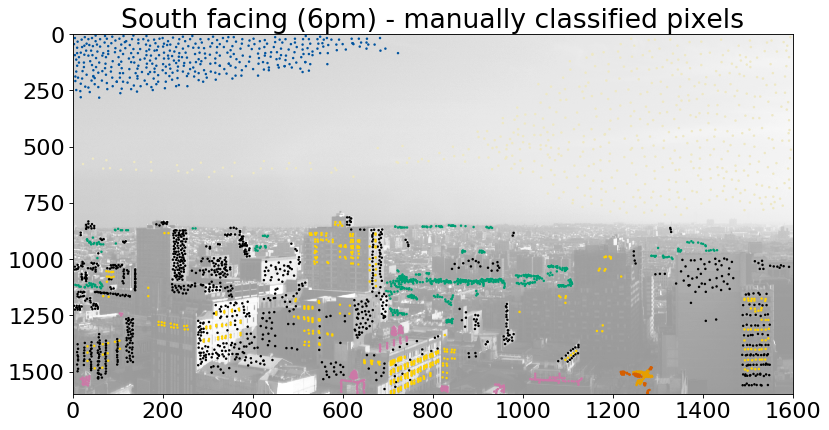

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.color import rgb2gray
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

grayscale0=rgb2gray(rgb0)

xpixels, ypixels = 1600, 1600
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
ax.imshow(grayscale0, cmap=plt.cm.gray, interpolation='none', aspect=0.5, alpha=0.4)

g1 = ([sky_coords0[:,1]], [sky_coords0[:,0]])
g2 = ([clouds_coords0[:,1]], [clouds_coords0[:,0]])
g3 = ([veg_coords0[:,1]], [veg_coords0[:,0]])
g4 = ([wtr_coords0[:,1]], [wtr_coords0[:,0]])
g5 = ([blt_coords0[:,1]], [blt_coords0[:,0]])
g6 = ([windows_coords0[:,1]], [windows_coords0[:,0]])
g7 = ([rds_coords0[:,1]], [rds_coords0[:,0]])
g8 = ([cars_coords0[:,1]], [cars_coords0[:,0]])
g9 = ([mtl_coords0[:,1]], [mtl_coords0[:,0]])

data = (g1, g2, g3,  g4, g5, g6, g7, g8, g9)
colors = ([0,0.32549,0.62353,1], #sky: UD blue
          [0.93333,0.9098,0.77255,1],#clouds: UD beige
          [0,0.61961,0.45098,1],  #veg: bluish green
          [0.33725,0.70588,0.91373,1], #water: sky blue
          [0,0,0,1], #built: black
          [1,0.82353,0,1],#windows: UD Gold
          [0.90196,0.62353,0,1],  #roads: orange
          [0.83529,0.36863,0,1],   #cars: vermillion
          [0.8,0.47451,0.65490,1]       #metal: reddish purple
         )
groups = ("sky", "clouds", "vegetation", "water", "built", "windows", "roads", "cars", "metal")

for data, color, group in zip(data, colors, groups):
  x, y = data
  plt.scatter(x, y, alpha=1.0, c=color, edgecolors='none', s=5, label=group)

ax.set_ylim(1600,0)
ax.set_xlim(0,1600)
ax.locator_params(nbins=7, axis='y')
plt.title('South facing (6pm) - manually classified pixels')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.show()
fig.savefig("./plots/Manually_classified_pixels_000.png", bbox_inches='tight')

### North Facing

In [13]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [14]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [15]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


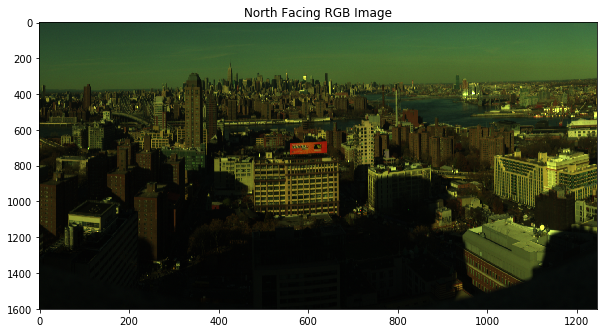

In [34]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

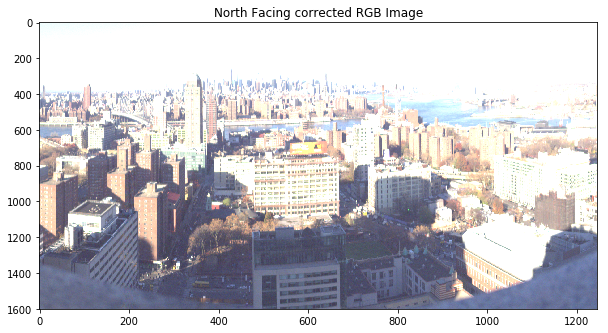

In [35]:
rgbn = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]].copy()
rgbn /= rgbn.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing corrected RGB Image')
ax.imshow(rgbn.clip(0, 1)**0.5, aspect=0.4)
plt.show()

In [36]:
# read manually selected coordinates files

#sky coordinates
sky_filen = open("../manual_classified_pixels/1_sky_coordinates_north.txt", "r")
sky_coordsn = sky_filen.readlines()
sky_filen.close()
sky_coordsn = np.array([point_from_string(line) for line in sky_coordsn])
print("sky:        ", sky_coordsn.shape)

#clouds coordinates
clouds_filen = open("../manual_classified_pixels/2_clouds_coordinates_north.txt", "r")
clouds_coordsn = clouds_filen.readlines()
clouds_filen.close()
clouds_coordsn = np.array([point_from_string(line) for line in clouds_coordsn])
print("clouds:     ", clouds_coordsn.shape)

#vegetation coordinates
veg_filen = open("../manual_classified_pixels/3_vegetation_coordinates_north.txt", "r")
veg_coordsn = veg_filen.readlines()
veg_filen.close()
veg_coordsn = np.array([point_from_string(line) for line in veg_coordsn])
print("vegetation: ", veg_coordsn.shape)

#water coordinates
wtr_filen = open("../manual_classified_pixels/4_water_coordinates_north.txt", "r")
wtr_coordsn = wtr_filen.readlines()
wtr_filen.close()
wtr_coordsn = np.array([point_from_string(line) for line in wtr_coordsn])
print("water:      ", wtr_coordsn.shape)

#buildings coordinates
blt_filen = open("../manual_classified_pixels/5_buildings_coordinates_north.txt", "r")
blt_coordsn = blt_filen.readlines()
blt_filen.close()
blt_coordsn = np.array([point_from_string(line) for line in blt_coordsn])
print("buildings:  ", blt_coordsn.shape)

#windows coordinates
windows_filen = open("../manual_classified_pixels/6_windows_coordinates_north.txt", "r")
windows_coordsn = windows_filen.readlines()
windows_filen.close()
windows_coordsn = np.array([point_from_string(line) for line in windows_coordsn])
print("windows:    ", windows_coordsn.shape)

#roads coordinates
rds_filen = open("../manual_classified_pixels/7_roads_coordinates_north.txt", "r")
rds_coordsn = rds_filen.readlines()
rds_filen.close()
rds_coordsn = np.array([point_from_string(line) for line in rds_coordsn])
print("road:       ", rds_coordsn.shape)

#cars coordinates
cars_filen = open("../manual_classified_pixels/8_cars_coordinates_north.txt", "r")
cars_coordsn = cars_filen.readlines()
cars_filen.close()
cars_coordsn = np.array([point_from_string(line) for line in cars_coordsn])
print("cars:       ", cars_coordsn.shape)

#metal coordinates
mtl_filen = open("../manual_classified_pixels/9_metal_coordinates_north.txt", "r")
mtl_coordsn = mtl_filen.readlines()
mtl_filen.close()
mtl_coordsn = np.array([point_from_string(line) for line in mtl_coordsn])
print("metal:      ", mtl_coordsn.shape)

sky:         (300, 2)
clouds:      (200, 2)
vegetation:  (700, 2)
water:       (620, 2)
buildings:   (1600, 2)
windows:     (600, 2)
road:        (250, 2)
cars:        (250, 2)
metal:       (185, 2)


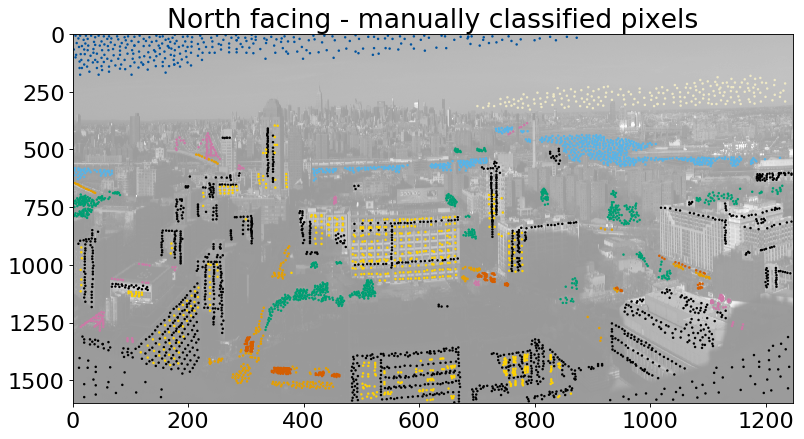

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.color import rgb2gray
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

grayscalen=rgb2gray(rgbn)

xpixels, ypixels = 1600, 1600
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
ax.imshow(grayscalen, cmap=plt.cm.gray, interpolation='none', aspect=0.4, alpha=0.4)

g1 = ([sky_coordsn[:,1]], [sky_coordsn[:,0]])
g2 = ([clouds_coordsn[:,1]], [clouds_coordsn[:,0]])
g3 = ([veg_coordsn[:,1]], [veg_coordsn[:,0]])
g4 = ([wtr_coordsn[:,1]], [wtr_coordsn[:,0]])
g5 = ([blt_coordsn[:,1]], [blt_coordsn[:,0]])
g6 = ([windows_coordsn[:,1]], [windows_coordsn[:,0]])
g7 = ([rds_coordsn[:,1]], [rds_coordsn[:,0]])
g8 = ([cars_coordsn[:,1]], [cars_coordsn[:,0]])
g9 = ([mtl_coordsn[:,1]], [mtl_coordsn[:,0]])

data = (g1, g2, g3,  g4, g5, g6, g7, g8, g9)
colors = ([0,0.32549,0.62353,1], #sky: UD blue
          [0.93333,0.9098,0.77255,1],#clouds: UD beige
          [0,0.61961,0.45098,1],  #veg: bluish green
          [0.33725,0.70588,0.91373,1], #water: sky blue
          [0,0,0,1], #built: black
          [1,0.82353,0,1],#windows: UD Gold
          [0.90196,0.62353,0,1],  #roads: orange
          [0.83529,0.36863,0,1],   #cars: vermillion
          [0.8,0.47451,0.65490,1]       #metal: reddish purple
         )

groups = ("sky", "clouds", "vegetation", "water", "built", "windows", "roads", "cars", "metal")

for data, color, group in zip(data, colors, groups):
  x, y = data
  plt.scatter(x, y, alpha=1.0, c=color, edgecolors='none', s=5, label=group)

ax.set_xlim(0,1247)
ax.locator_params(nbins=7, axis='y')
plt.title('North facing - manually classified pixels')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.show()
fig.savefig("./plots/Manually_classified_pixels_north.png", bbox_inches='tight')

### Plot mean standardized spectra

#### veg_00108

In [16]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


In [17]:
cube_std_2d = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
cube_std_3d = cube_std_2d.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])

In [18]:
sky_ind = np.arange(sky_coords.shape[0])
cube_sky_test = cube_std_3d[sky_coords[sky_ind[:], 0], sky_coords[sky_ind[:], 1], :]
clouds_ind = np.arange(clouds_coords.shape[0])
cube_clouds_test = cube_std_3d[clouds_coords[clouds_ind[:], 0], clouds_coords[clouds_ind[:], 1], :]
veg_ind = np.arange(veg_coords.shape[0])
cube_veg_test = cube_std_3d[veg_coords[veg_ind[:], 0], veg_coords[veg_ind[:], 1], :]
wtr_ind = np.arange(wtr_coords.shape[0])
cube_wtr_test = cube_std_3d[wtr_coords[wtr_ind[:], 0], wtr_coords[wtr_ind[:], 1], :]
blt_ind = np.arange(blt_coords.shape[0])
cube_blt_test = cube_std_3d[blt_coords[blt_ind[:], 0], blt_coords[blt_ind[:], 1], :]
windows_ind = np.arange(windows_coords.shape[0])
cube_windows_test = cube_std_3d[windows_coords[windows_ind[:], 0], windows_coords[windows_ind[:], 1], :]
rds_ind = np.arange(rds_coords.shape[0])
cube_rds_test = cube_std_3d[rds_coords[rds_ind[:], 0], rds_coords[rds_ind[:], 1], :]
cars_ind = np.arange(cars_coords.shape[0])
cube_cars_test = cube_std_3d[cars_coords[cars_ind[:], 0], cars_coords[cars_ind[:], 1], :]
mtl_ind = np.arange(mtl_coords.shape[0])
cube_mtl_test = cube_std_3d[mtl_coords[mtl_ind[:], 0], mtl_coords[mtl_ind[:], 1], :]

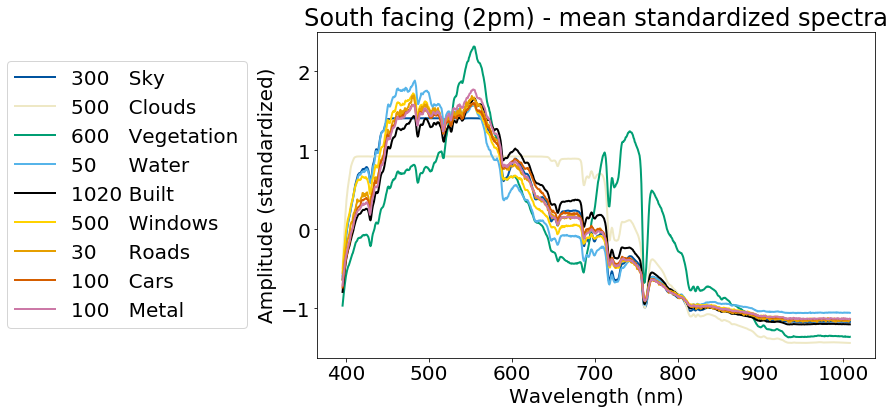

In [67]:
# plot mean spectra for training set together
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,6))
plt.title('South facing (2pm) - mean standardized spectra')
ax.plot(cube.waves, cube_sky_test.mean(0), color=[0,0.32549,0.62353], label="300   Sky", lw=2)
ax.plot(cube.waves, cube_clouds_test.mean(0), color=[0.93333,0.9098,0.77255], label="500   Clouds", lw=2)
ax.plot(cube.waves, cube_veg_test.mean(0), color=[0,0.61961,0.45098], label="600   Vegetation", lw=2)
ax.plot(cube.waves, cube_wtr_test.mean(0), color=[0.33725,0.70588,0.91373], label="50     Water", lw=2)
ax.plot(cube.waves, cube_blt_test.mean(0), color=[0,0,0], label="1020 Built", lw=2)
ax.plot(cube.waves, cube_windows_test.mean(0), color=[1,0.82353,0], label="500   Windows", lw=2)
ax.plot(cube.waves, cube_rds_test.mean(0), color=[0.90196,0.62353,0], label="30     Roads", lw=2)
ax.plot(cube.waves, cube_cars_test.mean(0), color=[0.83529,0.36863,0], label="100   Cars", lw=2)
ax.plot(cube.waves, cube_mtl_test.mean(0), color=[0.8,0.47451,0.65490], label="100   Metal", lw=2)
lgd = ax.legend(loc="center left", borderaxespad=-15.5)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Amplitude (standardized)")
plt.show()
fig.savefig("./plots/Mean_spectra_108_training_pixels_all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

#### veg_00000

In [38]:
# read manually selected coordinates files

#sky coordinates
sky_file0 = open("../manual_classified_pixels/1_sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print("sky:        ", sky_coords0.shape)

#clouds coordinates
clouds_file0 = open("../manual_classified_pixels/2_clouds_coordinates_000.txt", "r")
clouds_coords0 = clouds_file0.readlines()
clouds_file0.close()
clouds_coords0 = np.array([point_from_string(line) for line in clouds_coords0])
print("clouds:     ", clouds_coords0.shape)

#vegetation coordinates
veg_file0 = open("../manual_classified_pixels/3_vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print("vegetation: ", veg_coords0.shape)

#water coordinates
wtr_file0 = open("../manual_classified_pixels/4_water_coordinates_000.txt", "r")
wtr_coords0 = wtr_file0.readlines()
wtr_file0.close()
wtr_coords0 = np.array([point_from_string(line) for line in wtr_coords0])
print("water:      ", wtr_coords0.shape)

#buildings coordinates
blt_file0 = open("../manual_classified_pixels/5_buildings_coordinates_000.txt", "r")
blt_coords0 = blt_file0.readlines()
blt_file0.close()
blt_coords0 = np.array([point_from_string(line) for line in blt_coords0])
print("buildings:  ", blt_coords0.shape)

#windows coordinates
windows_file0 = open("../manual_classified_pixels/6_windows_coordinates_000.txt", "r")
windows_coords0 = windows_file0.readlines()
windows_file0.close()
windows_coords0 = np.array([point_from_string(line) for line in windows_coords0])
print("windows:    ", windows_coords0.shape)

#roads coordinates
rds_file0 = open("../manual_classified_pixels/7_roads_coordinates_000.txt", "r")
rds_coords0 = rds_file0.readlines()
rds_file0.close()
rds_coords0 = np.array([point_from_string(line) for line in rds_coords0])
print("road:       ", rds_coords0.shape)

#cars coordinates
cars_file0 = open("../manual_classified_pixels/8_cars_coordinates_000.txt", "r")
cars_coords0 = cars_file0.readlines()
cars_file0.close()
cars_coords0 = np.array([point_from_string(line) for line in cars_coords0])
print("cars:       ", cars_coords0.shape)

#metal coordinates
mtl_file0 = open("../manual_classified_pixels/9_metal_coordinates_000.txt", "r")
mtl_coords0 = mtl_file0.readlines()
mtl_file0.close()
mtl_coords0 = np.array([point_from_string(line) for line in mtl_coords0])
print("metal:      ", mtl_coords0.shape)

sky:         (400, 2)
clouds:      (500, 2)
vegetation:  (610, 2)
water:       (0,)
buildings:   (1200, 2)
windows:     (500, 2)
road:        (60, 2)
cars:        (55, 2)
metal:       (230, 2)


In [39]:
cube0_std_2d = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
cube0_std_3d = cube0_std_2d.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])

In [41]:
sky_ind0 = np.arange(sky_coords0.shape[0])
cube0_sky_test = cube0_std_3d[sky_coords0[sky_ind0[:], 0], sky_coords0[sky_ind0[:], 1], :]
clouds_ind0 = np.arange(clouds_coords0.shape[0])
cube0_clouds_test = cube0_std_3d[clouds_coords0[clouds_ind0[:], 0], clouds_coords0[clouds_ind0[:], 1], :]
veg_ind0 = np.arange(veg_coords0.shape[0])
cube0_veg_test = cube0_std_3d[veg_coords0[veg_ind0[:], 0], veg_coords0[veg_ind0[:], 1], :]
#wtr_ind0 = np.arange(wtr_coords0.shape[0])
#cube0_wtr_test = cube0_std_3d[wtr_coords0[wtr_ind0[:], 0], wtr_coords0[wtr_ind0[:], 1], :]
blt_ind0 = np.arange(blt_coords0.shape[0])
cube0_blt_test = cube0_std_3d[blt_coords0[blt_ind0[:], 0], blt_coords0[blt_ind0[:], 1], :]
windows_ind0 = np.arange(windows_coords0.shape[0])
cube0_windows_test = cube0_std_3d[windows_coords0[windows_ind0[:], 0], windows_coords0[windows_ind0[:], 1], :]
rds_ind0 = np.arange(rds_coords0.shape[0])
cube0_rds_test = cube0_std_3d[rds_coords0[rds_ind0[:], 0], rds_coords0[rds_ind0[:], 1], :]
cars_ind0 = np.arange(cars_coords0.shape[0])
cube0_cars_test = cube0_std_3d[cars_coords0[cars_ind0[:], 0], cars_coords0[cars_ind0[:], 1], :]
mtl_ind0 = np.arange(mtl_coords0.shape[0])
cube0_mtl_test = cube0_std_3d[mtl_coords0[mtl_ind0[:], 0], mtl_coords0[mtl_ind0[:], 1], :]

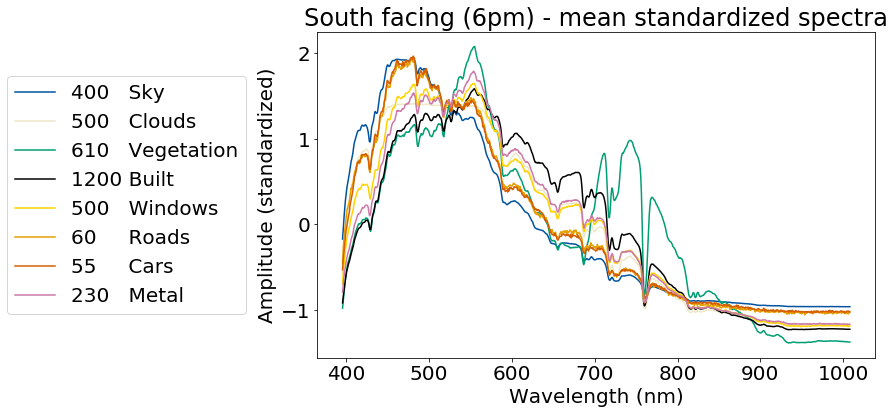

In [70]:
# plot mean spectra for training set together
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,6))
plt.title('South facing (6pm) - mean standardized spectra')
ax.plot(cube0.waves, cube0_sky_test.mean(0), color=[0,0.32549,0.62353], label="400   Sky", lw=2)
ax.plot(cube0.waves, cube0_clouds_test.mean(0), color=[0.93333,0.9098,0.77255], label="500   Clouds", lw=2)
ax.plot(cube0.waves, cube0_veg_test.mean(0), color=[0,0.61961,0.45098], label="610   Vegetation", lw=2)
#ax.plot(cube0.waves, cube0_wtr_test.mean(0), color=[0.33725,0.70588,0.91373], label="Water", lw=2)
ax.plot(cube0.waves, cube0_blt_test.mean(0), color=[0,0,0], label="1200 Built", lw=2)
ax.plot(cube0.waves, cube0_windows_test.mean(0), color=[1,0.82353,0], label="500   Windows", lw=2)
ax.plot(cube0.waves, cube0_rds_test.mean(0), color=[0.90196,0.62353,0], label="60     Roads", lw=2)
ax.plot(cube0.waves, cube0_cars_test.mean(0), color=[0.83529,0.36863,0], label="55     Cars", lw=2)
ax.plot(cube0.waves, cube0_mtl_test.mean(0), color=[0.8,0.47451,0.65490], label="230   Metal", lw=2)
lgd = ax.legend(loc="center left", borderaxespad=-15.5)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Amplitude (standardized)")
ax.locator_params(nbins=5, axis='y')
plt.show()
fig.savefig("./plots/Mean_spectra_000_training_pixels_all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

#### north facing

In [44]:
# read manually selected coordinates files

#sky coordinates
sky_filen = open("../manual_classified_pixels/1_sky_coordinates_north.txt", "r")
sky_coordsn = sky_filen.readlines()
sky_filen.close()
sky_coordsn = np.array([point_from_string(line) for line in sky_coordsn])
print("sky:        ", sky_coordsn.shape)

#clouds coordinates
clouds_filen = open("../manual_classified_pixels/2_clouds_coordinates_north.txt", "r")
clouds_coordsn = clouds_filen.readlines()
clouds_filen.close()
clouds_coordsn = np.array([point_from_string(line) for line in clouds_coordsn])
print("clouds:     ", clouds_coordsn.shape)

#vegetation coordinates
veg_filen = open("../manual_classified_pixels/3_vegetation_coordinates_north.txt", "r")
veg_coordsn = veg_filen.readlines()
veg_filen.close()
veg_coordsn = np.array([point_from_string(line) for line in veg_coordsn])
print("vegetation: ", veg_coordsn.shape)

#water coordinates
wtr_filen = open("../manual_classified_pixels/4_water_coordinates_north.txt", "r")
wtr_coordsn = wtr_filen.readlines()
wtr_filen.close()
wtr_coordsn = np.array([point_from_string(line) for line in wtr_coordsn])
print("water:      ", wtr_coordsn.shape)

#buildings coordinates
blt_filen = open("../manual_classified_pixels/5_buildings_coordinates_north.txt", "r")
blt_coordsn = blt_filen.readlines()
blt_filen.close()
blt_coordsn = np.array([point_from_string(line) for line in blt_coordsn])
print("buildings:  ", blt_coordsn.shape)

#windows coordinates
windows_filen = open("../manual_classified_pixels/6_windows_coordinates_north.txt", "r")
windows_coordsn = windows_filen.readlines()
windows_filen.close()
windows_coordsn = np.array([point_from_string(line) for line in windows_coordsn])
print("windows:    ", windows_coordsn.shape)

#roads coordinates
rds_filen = open("../manual_classified_pixels/7_roads_coordinates_north.txt", "r")
rds_coordsn = rds_filen.readlines()
rds_filen.close()
rds_coordsn = np.array([point_from_string(line) for line in rds_coordsn])
print("road:       ", rds_coordsn.shape)

#cars coordinates
cars_filen = open("../manual_classified_pixels/8_cars_coordinates_north.txt", "r")
cars_coordsn = cars_filen.readlines()
cars_filen.close()
cars_coordsn = np.array([point_from_string(line) for line in cars_coordsn])
print("cars:       ", cars_coordsn.shape)

#metal coordinates
mtl_filen = open("../manual_classified_pixels/9_metal_coordinates_north.txt", "r")
mtl_coordsn = mtl_filen.readlines()
mtl_filen.close()
mtl_coordsn = np.array([point_from_string(line) for line in mtl_coordsn])
print("metal:      ", mtl_coordsn.shape)

sky:         (300, 2)
clouds:      (200, 2)
vegetation:  (700, 2)
water:       (620, 2)
buildings:   (1600, 2)
windows:     (600, 2)
road:        (250, 2)
cars:        (250, 2)
metal:       (185, 2)


In [45]:
cuben_std_2d = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
cuben_std_3d = cuben_std_2d.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])

In [46]:
sky_indn = np.arange(sky_coordsn.shape[0])
cuben_sky_test = cuben_std_3d[sky_coordsn[sky_indn[:], 0], sky_coordsn[sky_indn[:], 1], :]
clouds_indn = np.arange(clouds_coordsn.shape[0])
cuben_clouds_test = cuben_std_3d[clouds_coordsn[clouds_indn[:], 0], clouds_coordsn[clouds_indn[:], 1], :]
veg_indn = np.arange(veg_coordsn.shape[0])
cuben_veg_test = cuben_std_3d[veg_coordsn[veg_indn[:], 0], veg_coordsn[veg_indn[:], 1], :]
wtr_indn = np.arange(wtr_coordsn.shape[0])
cuben_wtr_test = cuben_std_3d[wtr_coordsn[wtr_indn[:], 0], wtr_coordsn[wtr_indn[:], 1], :]
blt_indn = np.arange(blt_coordsn.shape[0])
cuben_blt_test = cuben_std_3d[blt_coordsn[blt_indn[:], 0], blt_coordsn[blt_indn[:], 1], :]
windows_indn = np.arange(windows_coordsn.shape[0])
cuben_windows_test = cuben_std_3d[windows_coordsn[windows_indn[:], 0], windows_coordsn[windows_indn[:], 1], :]
rds_indn = np.arange(rds_coordsn.shape[0])
cuben_rds_test = cuben_std_3d[rds_coordsn[rds_indn[:], 0], rds_coordsn[rds_indn[:], 1], :]
cars_indn = np.arange(cars_coordsn.shape[0])
cuben_cars_test = cuben_std_3d[cars_coordsn[cars_indn[:], 0], cars_coordsn[cars_indn[:], 1], :]
mtl_indn = np.arange(mtl_coordsn.shape[0])
cuben_mtl_test = cuben_std_3d[mtl_coordsn[mtl_indn[:], 0], mtl_coordsn[mtl_indn[:], 1], :]

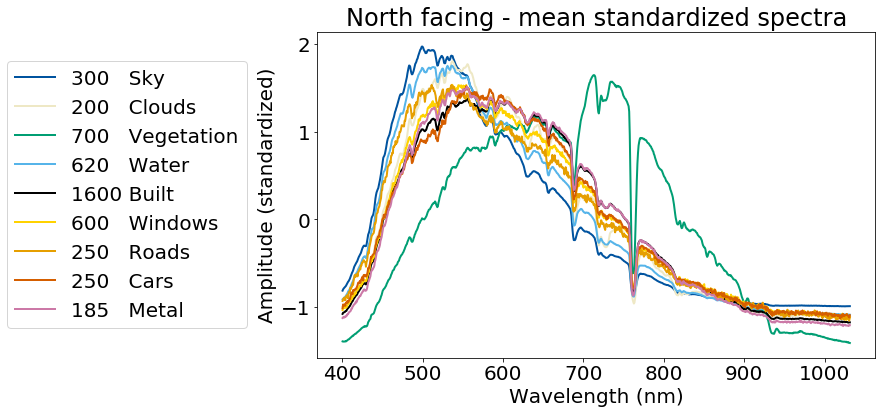

In [73]:
# plot mean spectra for training set together
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
       'size' : 20}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,6))
plt.title('North facing - mean standardized spectra')
ax.plot(cube_north.waves, cuben_sky_test.mean(0), color=[0,0.32549,0.62353], label="300   Sky", lw=2)
ax.plot(cube_north.waves, cuben_clouds_test.mean(0), color=[0.93333,0.9098,0.77255], label="200   Clouds", lw=2)
ax.plot(cube_north.waves, cuben_veg_test.mean(0), color=[0,0.61961,0.45098], label="700   Vegetation", lw=2)
ax.plot(cube_north.waves, cuben_wtr_test.mean(0), color=[0.33725,0.70588,0.91373], label="620   Water", lw=2)
ax.plot(cube_north.waves, cuben_blt_test.mean(0), color=[0,0,0], label="1600 Built", lw=2)
ax.plot(cube_north.waves, cuben_windows_test.mean(0), color=[1,0.82353,0], label="600   Windows", lw=2)
ax.plot(cube_north.waves, cuben_rds_test.mean(0), color=[0.90196,0.62353,0], label="250   Roads", lw=2)
ax.plot(cube_north.waves, cuben_cars_test.mean(0), color=[0.83529,0.36863,0], label="250   Cars", lw=2)
ax.plot(cube_north.waves, cuben_mtl_test.mean(0), color=[0.8,0.47451,0.65490], label="185   Metal", lw=2)
lgd = ax.legend(loc="center left", borderaxespad=-15.5)
ax.locator_params(nbins=5, axis='y')
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Amplitude (standardized)")
plt.show()
fig.savefig("./plots/Mean_spectra_north_training_pixels_all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')